In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df_housing = pd.read_csv('../data/week6_lab_GradientDescent_data.csv')

In [4]:
df_housing.head()
df_housing.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

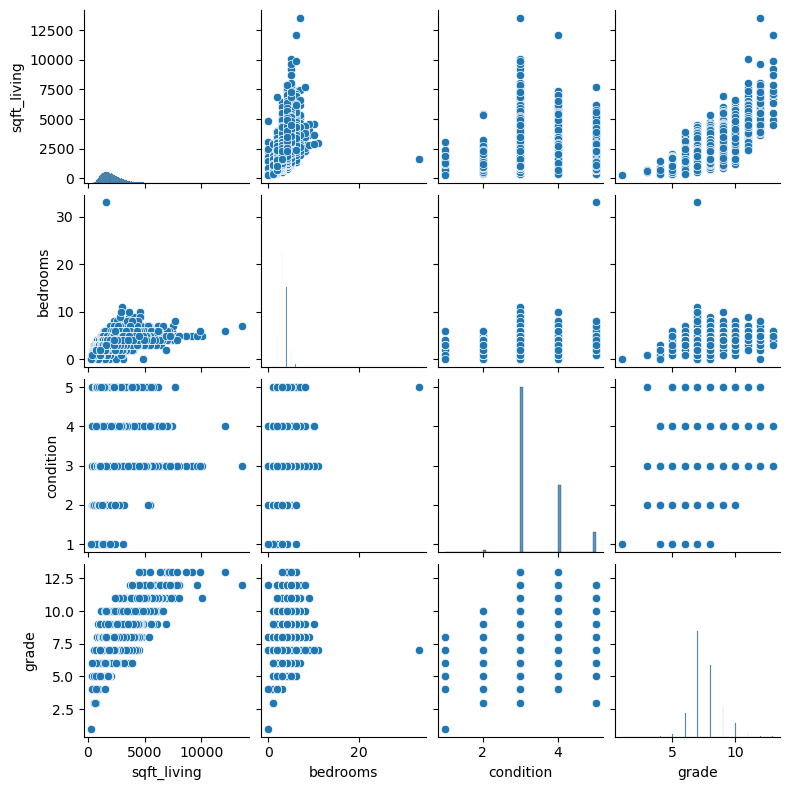

In [5]:
data = df_housing[['sqft_living', 'bedrooms', 'condition', 'grade']].dropna()
sns.pairplot(data, height=2.0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[['sqft_living', 'bedrooms', 'condition']], data['grade'], test_size=0.33, random_state=371)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14480, 3)
(7133, 3)
(14480,)
(7133,)


[sklearn: SGDRegresor documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)

In [7]:
sgd = SGDRegressor(learning_rate='constant', eta0=0.01, random_state=371)
sgd.fit(X_train, y_train)
sgd.coef_
sgd.intercept_
sgd.n_iter_

8

In [8]:
y_pred = sgd.predict(X_test)

In [9]:
mean_squared_error(y_test, y_pred)

3.5788228094005765e+30

# Will compare performance (mean_squared_error, n_iter) when varying following hyperparameters
- step size (w/ constant learning rate)
- non-constant learning rate

In [10]:
etas = [0.001, 0.01, 0.1, 1]
mses = []
niters = []

for eta in etas:
    sgd = SGDRegressor(learning_rate="constant", eta0=eta, random_state=371)
    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    niter = sgd.n_iter_
    
    mses.append(mse)
    niters.append(niter)

for i in range(len(etas)):
    print("eta: " + str(etas[i]) + " mse: " + str(mses[i]) + " niter: " + str(niters[i]))

eta: 0.001 mse: 4.216591550463187e+28 niter: 8
eta: 0.01 mse: 3.5788228094005765e+30 niter: 8
eta: 0.1 mse: 3.566832408687393e+32 niter: 8
eta: 1 mse: 3.9774261564479396e+34 niter: 8


As the step size increases, the mse increases dramatically, indicating that larger step sizes are causing the model to perform worse, possibly due to overshooting the minimum of the loss function. All models converged in 8 iterations, which suggests that convergence speed isn't significantly affected by the step size in this case.

In [11]:
lrs = ["optimal", "invscaling", "adaptive"]
mses = []
niters = []

for lr in lrs:
    sgd = SGDRegressor(learning_rate=lr, eta0=0.01, random_state=371)
    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    niter = sgd.n_iter_
    
    mses.append(mse)
    niters.append(niter)
    
for i in range(len(lrs)):
    print("lr: " + str(lrs[i]) + " mse: " + str(mses[i]) + " niter: " + str(niters[i]))

lr: optimal mse: 1.5525216224639407e+32 niter: 516
lr: invscaling mse: 7.3281025478531e+28 niter: 183
lr: adaptive mse: 9.167553210460777e+24 niter: 278


The different learning rates have hugely different mses, with adaptive performing the best in terms of mse, suggesting it is better suited for this data. The number of iterations to convergence varied significantly among these methods.

# Preprocessing data
Using [slearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [12]:
reg = make_pipeline(StandardScaler(), SGDRegressor(learning_rate='optimal', eta0=1e-12, random_state=371))
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

0.5580187905812127

# Will compare performance (MSE, n_iter) with preprocessed gradient descent when varying following hyperparameters:
- step size (w/ constant learning rate)
- non-constant learning rate

In [13]:
etas = [0.001, 0.01, 0.1, 1]
mses = []
niter = []

for eta in etas:
    reg = make_pipeline(StandardScaler(), SGDRegressor(learning_rate="constant", eta0=eta, random_state=371))
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    niter = reg.named_steps.sgdregressor.n_iter_
    
    mses.append(mse)
    niters.append(niter)
    
for i in range(len(etas)):
    print("eta: " + str(etas[i]) + " mse: " + str(mses[i]) + " niter: " + str(niters[i]))

eta: 0.001 mse: 0.5568953949674128 niter: 516
eta: 0.01 mse: 0.5892830040226942 niter: 183
eta: 0.1 mse: 0.6064948138413563 niter: 278
eta: 1 mse: 6.552047602634333e+24 niter: 7


As the step size increases, the mse initially increases slightly but then dramatically spikes for eta: 1, indicating that smaller step sizes are generally more effective, with very large steps causing instability in convergence. The number of iterations required varies with different step sizes, with no clear trend, suggesting that the convergence speed is not directly proportional to the step size in this context.

In [14]:
lrs = ["optimal", "invscaling", "adaptive"]
mses = []
niters = []

for lr in lrs:
    reg = make_pipeline(StandardScaler(), SGDRegressor(learning_rate=lr, eta0=0.01, random_state=371))
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    niter = reg.named_steps.sgdregressor.n_iter_
    
    mses.append(mse)
    niters.append(niter)
    
for i in range(len(lrs)):
    print("lr: " + str(lrs[i]) + " mse: " + str(mses[i]) + " niter: " + str(niters[i]))

lr: optimal mse: 0.5580187905812127 niter: 28
lr: invscaling mse: 0.5524993840839114 niter: 7
lr: adaptive mse: 0.5484345420039571 niter: 42


The mse for different learning rate schedules are quite similar, all providing relatively good performance, but the adaptive learning rate results in the lowest mse, indicating it might be slightly more effective for this particular dataset. The number of iterations varies across the different learning rate schedules, with invscaling requiring the fewest iterations, suggesting it might be more efficient in terms of computation time.